Name: Dalevinder Singh

PI: F1067971

## Setup

In [1]:
import tensorflow as tf
import numpy as np
import csv
import os
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, datasets, metrics, Sequential, utils
from tensorflow.keras.layers import *
from IPython.display import HTML, display
import matplotlib.pyplot as plt
%matplotlib inline

## Define Constants

In [2]:
data_dir = '/datasets/treesat'
label_level = 2

In [3]:
IMAGE_RESCALE = (288, 288)
input_shape = (IMAGE_RESCALE[0], IMAGE_RESCALE[1], 4)
batch_size = 128
label_key = f'level_{label_level}'

## Load Data

In [4]:
train_file_labels = tf.data.experimental.make_csv_dataset(
    os.path.join(data_dir, 'train_file_labels.csv'), batch_size=batch_size, num_epochs=1)
train_file_labels = train_file_labels.unbatch()

In [5]:
validation_file_labels = tf.data.experimental.make_csv_dataset(
    os.path.join(data_dir, 'validation_file_labels.csv'), batch_size=batch_size, num_epochs=1)
validation_file_labels = validation_file_labels.unbatch()

In [6]:
test_file_labels = tf.data.experimental.make_csv_dataset(
    os.path.join(data_dir, 'test_file_labels.csv'), batch_size=batch_size, shuffle_buffer_size=1,
    num_epochs=1)
test_file_labels = test_file_labels.unbatch()

In [7]:
encoder_vocab_file = os.path.join(data_dir, f'level_{label_level}_vocabulary.txt')
label_encoder = StringLookup(vocabulary=encoder_vocab_file, num_oov_indices=0, output_mode='one_hot')

num_classes = len(label_encoder.get_vocabulary())

label_lookup = {i: n for i, n in enumerate(label_encoder.get_vocabulary())}
label_lookup

{0: 'larch',
 1: 'cleared',
 2: 'beech',
 3: 'oak',
 4: 'douglas fir',
 5: 'pine',
 6: 'fir',
 7: 'short-lived deciduous',
 8: 'long-lived deciduous',
 9: 'spruce'}

## Class Distribution

In [8]:
class_counts = train_file_labels.map(lambda fl: label_encoder(fl[label_key]))
class_counts = class_counts.reduce(tf.zeros((num_classes,)),
                             lambda o, l: tf.math.add(o, l))
class_counts

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([2145., 2844., 4508., 5515., 1896., 5324.,  687., 4131., 4118.,
       4098.], dtype=float32)>

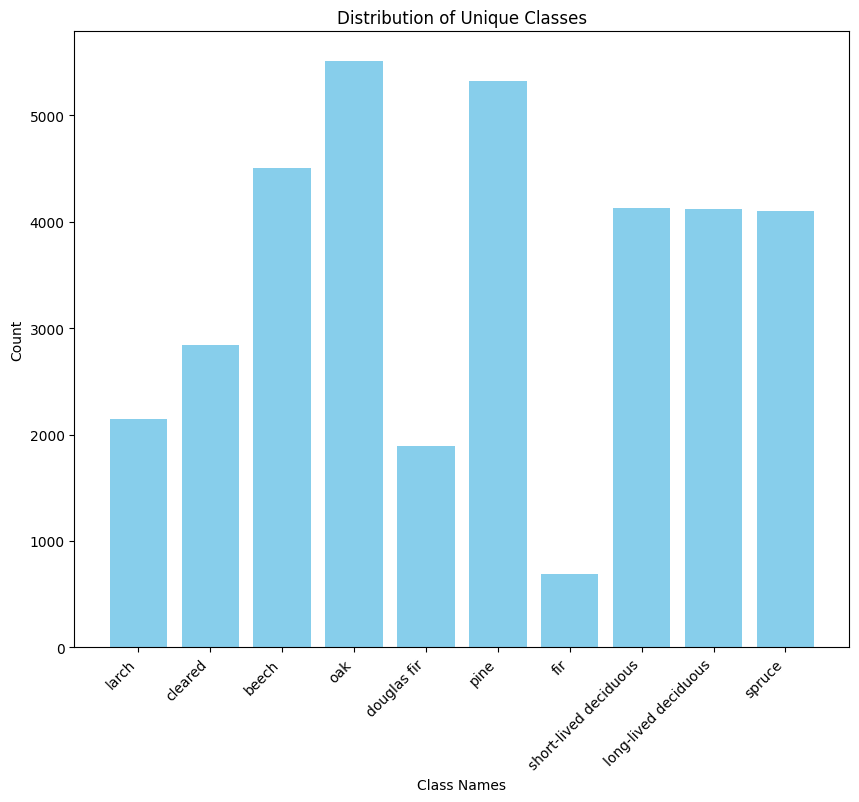

In [9]:
# Plot distribution using class names
plt.figure(figsize=(10, 8))
plt.bar(label_encoder.get_vocabulary(), class_counts.numpy(), color='skyblue')
plt.xlabel("Class Names")
plt.ylabel("Count")
plt.title("Distribution of Unique Classes")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()  # Display the plotted distribution

## Define Load Image and Add Weight Functions

In [10]:
# Adjusted load_image function to accept file_path and label separately
def load_image(file_path, label):
    # read the image from disk, decode it, resize it, and scale the pixels intensities to the range [0, 1]
    image = tf.io.read_file(file_path)
    image = tf.io.decode_png(image, channels=4)
    image = tf.image.resize(image, IMAGE_RESCALE)
    image /= 255.0
    
    # grab the label and encode it
    encoded_label = label_encoder(label)
    
    # return the image and the one-hot encoded label
    return image, encoded_label

In [11]:
# Function to add the weight to each image label pair
def add_weight(image, one_hot_label):
    label = tf.argmax(one_hot_label)
    return image, one_hot_label, class_weights[label]

## Create Training, Validation and Test Data

In [12]:
train_data = train_file_labels.map(lambda fl: (fl['file_name'], fl[label_key]), 
                                      num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(200)
train_data = train_data.map(load_image, 
                                      num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

In [13]:
validation_data = validation_file_labels.map(lambda fl: (fl['file_name'], fl[label_key]), 
                                      num_parallel_calls=tf.data.AUTOTUNE)
validation_data = validation_data.map(load_image, 
                                      num_parallel_calls=tf.data.AUTOTUNE)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.prefetch(tf.data.AUTOTUNE)

In [14]:
test_data = test_file_labels.map(lambda fl: (fl['file_name'], fl[label_key]), 
                                      num_parallel_calls=tf.data.AUTOTUNE)

test_data = test_data.map(load_image, 
                                      num_parallel_calls=tf.data.AUTOTUNE)

test_data = test_data.batch(batch_size)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

# Prevent any shuffling
test_data = test_data.shuffle(buffer_size=1)

## Create Baseline Model

In [15]:
model_input = Input(shape=input_shape) # (288,288,4)
        
l1 = Conv2D(filters=8, kernel_size=(5, 5), padding='same', activation='relu')(model_input)
l2 = Conv2D(filters=8, kernel_size=(5, 5), padding='same', activation='relu')(l1)
l3 = MaxPooling2D(pool_size=(2, 2))(l2)
l4 = Dropout(0.2)(l3) # (144,144,8)

# Adjust l4 to the same dimensions and depth as l12 (36,36,24)
r1a = Conv2D(filters=24, kernel_size=(1,1), strides=4)(l4)

l5 = Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu')(l4)
l6 = Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu')(l5)
l7 = MaxPooling2D(pool_size=(2, 2))(l6)
l8 = Dropout(0.2)(l7) # (72,72,16)

# Adjust l8 to the same dimensions and depth as l15 (18,18,32)
r2a = Conv2D(filters=32, kernel_size=(1,1), strides=4)(l8)

l9 = Conv2D(filters=24, kernel_size=(3, 3), padding='same', activation='relu')(l8)
l10 = Conv2D(filters=24, kernel_size=(3, 3), padding='same', activation='relu')(l9)
l11 = MaxPooling2D(pool_size=(2, 2))(l10)
l12 = Dropout(0.2)(l11) # (36,36,24)

# Make connection between l4 and l12
r1b = Add()([r1a, l12])

l13 = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(r1b)
l14 = MaxPooling2D(pool_size=(2, 2))(l13)
l15 = Dropout(0.2)(l14) # (18,18,32)

# Make connection between l8 and l15
r2b = Add()([r2a, l15])

l16 = Flatten()(r2b)
l17 = Dense(128, activation='relu')(l16)
l18 = Dropout(0.5)(l17)
l19 = Dense(num_classes, activation='softmax')(l18)

model_0 = tf.keras.Model(inputs=model_input, outputs=l19, name='res_model')

model_0.summary()

Model: "res_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 288, 288, 4)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 288, 288, 8)          808       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 288, 288, 8)          1608      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 144, 144, 8)          0         ['conv2d_1[0][0]']            
 D)                                                                                       

In [16]:
model_0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [17]:
# Disable optimizer to prevent warning during training

# Retrieve the current configuration of the TensorFlow session
config = tf.config.optimizer.get_experimental_options()

# Set the layout optimizer to False to disable it
config['layout_optimizer'] = False

# Apply the new configuration
tf.config.optimizer.set_experimental_options(config)

In [18]:
# history = model_0.fit(
#     train_data,
#     epochs=25,
#     validation_data=validation_data,
#     verbose=0
# )

## Cache Results

In [19]:
# # Save model
# model_0.save('residual.keras')

# # Save history
# with open('residual_history.json', 'w') as f:
#     json.dump(history.history, f)

In [20]:
# Load model
residual = tf.keras.models.load_model('residual.keras')

# Load history
with open('residual_history.json') as f:
    residual_history = json.load(f)

## View Training

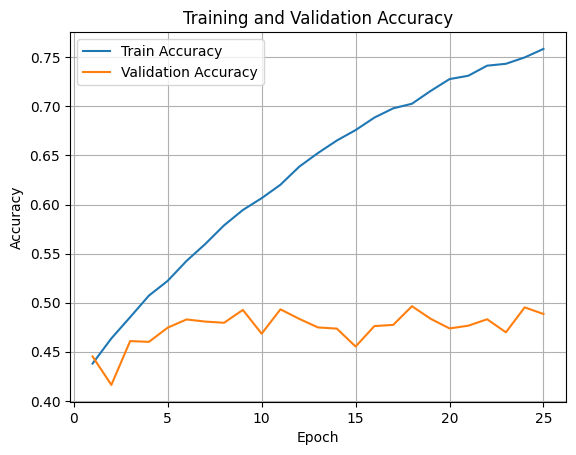

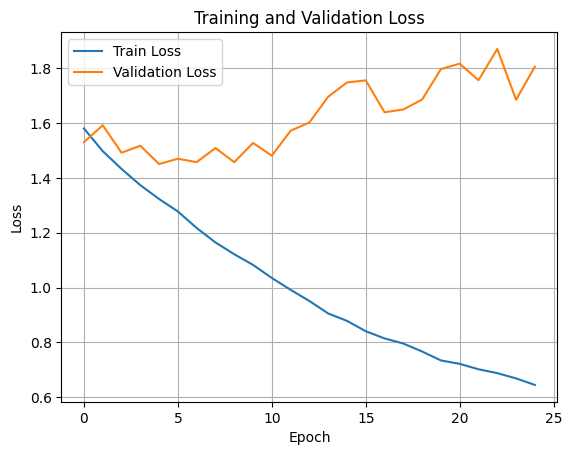

In [21]:
import matplotlib.pyplot as plt

# Assuming history contains the training history returned by model.fit
train_loss = residual_history['loss']
val_loss = residual_history['val_loss']
train_acc = residual_history['accuracy']
val_acc = residual_history['val_accuracy']

# Define number of epochs
epochs = range(1, len(train_acc)+1)

# Plot accuracy
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Evaluate the Model

In [22]:
residual.evaluate(test_data, return_dict=True)

79/79 [==============================] - 27s 293ms/step - loss: 1.7947 - accuracy: 0.4936


{'loss': 1.7947381734848022, 'accuracy': 0.4935992956161499}

In [23]:
test_predictions = residual.predict(test_data)

79/79 [==============================] - 22s 279ms/step


In [24]:
predict_labels = np.argmax(test_predictions, axis=1)

In [25]:
test_labels = np.array(list(test_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
test_labels = np.argmax(test_labels, axis=1)

## Confusion Matrix

In [26]:
cm = tf.math.confusion_matrix(test_labels, predict_labels).numpy()
cm

array([[154,   5,  37,  27,  67, 152,   6,  50,  64,  75],
       [  5, 657,  80,  37,   3,  15,   1,  34,  24,  31],
       [ 11,  43, 708, 164,   4,  13,   2,  74, 218,  36],
       [ 19,  34, 258, 830,   8,  30,   1,  81, 287,  19],
       [ 56,  12,  24,  12, 174,  96,  10,  20,  17, 121],
       [115,  14,  34,  42,  84, 878,  11,  87,  55, 136],
       [ 29,   0,  11,  10,  43,  27,  27,  12,  10,  21],
       [ 46,  53, 170, 202,  31, 118,   3, 259, 195,  53],
       [ 26,  38, 348, 261,   2,  19,   0,  73, 439,  45],
       [ 32,  29,  39,  25,  40,  64,   5,  31,  31, 848]], dtype=int32)

In [27]:
def pretty_cm(cm):
    result_table  = '<h3>Confusion matrix</h3>\n'
    result_table += '<table border=1>\n'
    result_table += f'<tr><td>&nbsp;</td><td>&nbsp;</td><th colspan={len(label_lookup)}>Predicted labels</th></tr>\n'
    result_table += '<tr><td>&nbsp;</td><td>&nbsp;</td>'

    for _, cn in sorted(label_lookup.items()):
        result_table += f'<td><strong>{cn}</strong></td>'
    result_table += '</tr>\n'

    result_table += '<tr>\n'
    result_table += f'<th rowspan={len(label_lookup) + 1}>Actual labels</th>\n'

    for ai, an in sorted(label_lookup.items()):
        result_table += '<tr>\n'
        result_table += f'  <td><strong>{an}</strong></td>\n'
        for pi, pn in sorted(label_lookup.items()):
            result_table += f'  <td>{cm[ai, pi]}</td>\n'
        result_table += '</tr>\n'
    result_table += "</table>"
    # print(result_table)
    display(HTML(result_table))

In [28]:
pretty_cm(cm)